In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_roc_curve
from scipy import interp
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

Xtest = np.loadtxt("Xtest.csv", delimiter=' ')
Xtrain = np.loadtxt("Xtrain.csv", delimiter=' ' )
Ytrain = np.loadtxt("Ytrain.csv", delimiter=' ')

In [24]:
## ROC-AUC score function
def ROC_AUC(X):
    auc =[]
    for i, (train, test) in enumerate(skf.split(X, Ytrain)):
        sknn.fit(X[train], Ytrain[train])
        viz = roc_auc_score(Ytrain[test], sknn.predict(X[test]))
        auc.append(viz)
    
    print(auc)
    print("AUC-ROC: %0.2f (+/- %0.2f)" % (np.mean(auc), np.std(auc) * 2))
    print("Mean :", np.mean(auc), "Standard Deviation:", np.std(auc))

i) 

There are 3000 rows (images) of training data with corespoinding 3000 labels. 

In [2]:
print(Xtrain.shape)
print(Ytrain.shape)

(3000, 784)
(3000,)


The images depict clothing, shoes, purses. The classification rule is not clear for me.

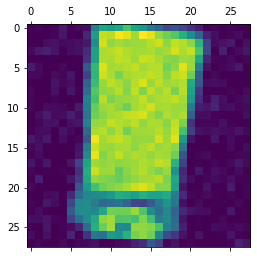

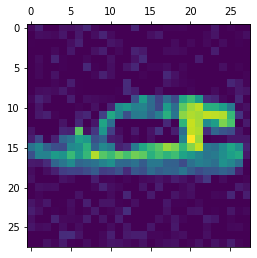

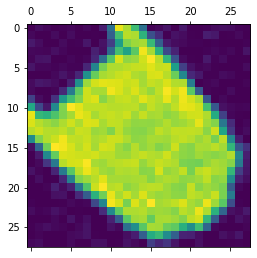

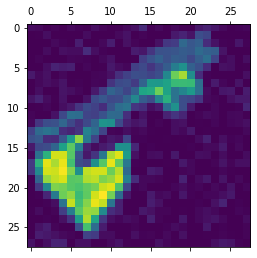

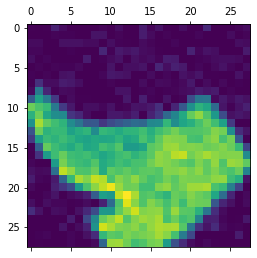

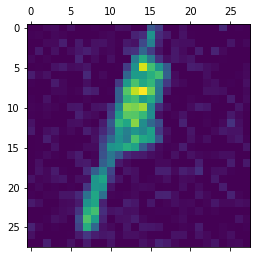

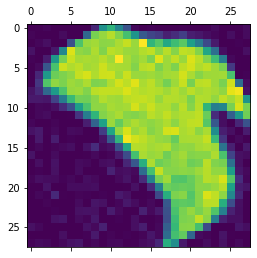

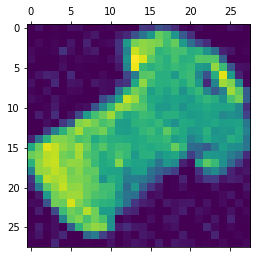

In [2]:
pos = Xtrain[Ytrain == 1]
neg = Xtrain[Ytrain == -1]
for i in range(10,14): 
    image_pos = np.reshape(pos[i], (28,28))
    image_neg = np.reshape(neg[i], (28,28))
    plt.matshow(image_pos)
    plt.matshow(image_neg)

ii) 

There are 1821 negatives and 1179 positive labels. Thus, the data is moderately imbalanced with a rough 60/40 split (dominated by negatives).

In [16]:
np.unique(Ytrain, return_counts=True)

(array([-1.,  1.]), array([1821, 1179]))

iii)


Due to the imbalance of the data, accuracy seems to be not the most appropriate performace evaluation tool owing to its bias toward the dominant category. Thus, AUC-ROC or AUC-PR are prefered options. The choice among these two metrics depends on the severity of the imbalance and the weight we put on correctly predicting the positive class (and thus precision). Since (1) the skew of the data is not severe (60/40), (2) no information is given about the goals of prediction and the fact that (3) the nature of the data (clothing) does not suggest that False Positives or False Negatives are more costly, I decided to use AUC-ROC as the performace evaluation metric. 

iv)

In general, a random classifier is expected to predict 50% of the labels correctly, yet we could derive a slightly more sphisticated expectation of the random classifier which would allow to incorporate different rates of predicting a certain group (predicting everything is of one class is as random as predicting 50/50 split). Accuracy is defined as a ratio of correctly labeled instances (True positives + True negetives) to the total population. To calculate expected confussion matrix terms, let's define $q$ as a probability that a random classifier assigns a positive label to a random input. In addition, recall that our traiingn data has 60% of negative and 40% of positive indtances. Then the expected proportions of all the confussion matrix terms are:

$TP = 0.4q \\
TN = (1-q)0.6 \\
FP = 0.6q\\
FN = (1-q)0.4$

Hence the expected accuracy of a random classifier is $TP+TN = 0.6-0.2q$, which for $q=0.5$ results in accuracy being 50%. 

v)

AUC-ROC curve is defined as the are under the true positive rate (TPR) against the false positive rate (FPR) curve. 

$TPR = \frac{TP}{FN+TP}= \frac{0.4q}{(1-q)0.4+0.4}=q \\
FPR = \frac{FP}{FP+TN}= \frac{0.6q}{(1-q)0.6+0.6}=q$

Hence the expectation of TPR over the range of FPR is:

$\int_0^1qdq=\frac{q^2}{2}|_0^1=1/2$

And since the expected AUC-ROC does not depend on the proportion of the data, the same result holds for the testing data.

AUC-PR, on the other hand is defined as the are under the precisiona against TPR curve. For the testing data is follows that:

$Precision = \frac{TP}{TP+FP}=\frac{0.4q}{0.4q+0.6q}=0.4$

Hence the expected training AUC-PR is

$\int_0^10.4qd=0.4q|_0^1 = 0.4$

By the same reasoning, it follows that expected random classifier AUC-PR for the testing data would be equal to the proportion of positive items in a data.

## Question 2
### i)

In [3]:
sknn = KNeighborsClassifier(n_neighbors=1)

skf = StratifiedKFold(n_splits=5)

scores = cross_val_score(sknn, Xtrain, Ytrain, cv=skf)

/Users/MacBook_Retina_2015_256Gb/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [36]:
# Accuracy summary
print(scores)

[0.77833333 0.75333333 0.74       0.75833333 0.74      ]
Accuracy: 0.75 (+/- 0.03)
0.7539999999999999 0.01416568624058385


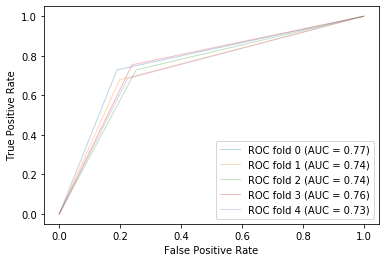

In [85]:
# AUC-ROC for each fold
aucs = []

fig, ax = plt.subplots()
for i, (train, test) in enumerate(skf.split(Xtrain, Ytrain)):
    sknn.fit(Xtrain[train], Ytrain[train])
    viz = plot_roc_curve(sknn, Xtrain[test], Ytrain[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    aucs.append(viz.roc_auc)

In [84]:
# Showing the AUC of ROC
aucs

[]

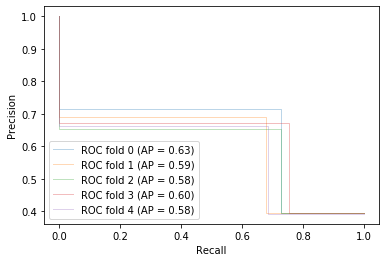

In [80]:
# AUC-PR curve
fig, ax = plt.subplots()
for i, (train, test) in enumerate(skf.split(Xtrain, Ytrain)):
    sknn.fit(Xtrain[train], Ytrain[train])
    viz = plot_precision_recall_curve(sknn, Xtrain[test], Ytrain[test],
                         name='PR fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)

In [81]:
# Testing the accuracy of the PR scores via differnt function
AP =[]
for i, (train, test) in enumerate(skf.split(Xtrain, Ytrain)):
    sknn.fit(Xtrain[train], Ytrain[train])
    average_precision = average_precision_score(Ytrain[test], sknn.predict(Xtrain[test]))
    AP.append(average_precision)
    
print(AP)

[0.6268157629462925, 0.5942294954217806, 0.5814997431946585, 0.6032864300181217, 0.5772515541546274]


### ii)



In [82]:
# Basic summary statistics of accuracy
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(scores.mean(), scores.std())

Accuracy: 0.75 (+/- 0.03)
0.7539999999999999 0.01416568624058385


In [86]:
# Basic summary statistics of AUC - ROC
print("AUC-ROC: %0.2f (+/- %0.2f)" % (np.mean(aucs), np.std(aucs) * 2))
print(np.mean(aucs), np.std(aucs))

AUC-ROC: 0.75 (+/- 0.03)
0.7471158478085845 0.014382049358744492


In [87]:
# Basic summary statistics of AUC - PR
print("AUC-PR: %0.2f (+/- %0.2f)" % (np.mean(AP), np.std(AP) * 2))
print(np.mean(AP), np.std(AP))

AUC-ROC: 0.60 (+/- 0.04)
0.5966165971470961 0.017695754878847423


### iii)

I will implement the following transformations: scaling, scaling to a range (between 0:1 and -1:1), mapping to uniform and Gaussian distributions and normalization. Sparse data transformations will not be applied because the data is not sparse - all needed values are present. Robust scaling, albeit not neccesary due to the the abscence of strong outliers, will still be conducted to deduce the importance of extreme values.

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [20]:
# Scaling
scaling = preprocessing.StandardScaler().fit(Xtrain)
Xscale = scaling.transform(Xtrain)

scaled_scores = ROC_AUC(Xscale)

[0.7318401937046004, 0.7423170050288695, 0.764993481095176, 0.7763317191283293, 0.7461964441853688]
AUC-ROC: 0.75 (+/- 0.03)
Mean : 0.7523357686284688 Standard Deviation: 0.016088249410198697


In [16]:
# MinMax Scaler
min_max_scaler = preprocessing.MinMaxScaler()
Xtrain_minmax = min_max_scaler.fit_transform(Xtrain)

minmax_scores = ROC_AUC(Xtrain_minmax)

[0.7626420189979511, 0.7387083255727324, 0.7387781709815608, 0.7589867759359284, 0.7294666278053046]
AUC-ROC: 0.75 (+/- 0.03)
Mean : 0.7457163838586955 Standard Deviation: 0.012836562479209931


In [17]:
# MaxAbs Scaler - must be centered at zero a priori

demeaning = preprocessing.StandardScaler(with_std=False).fit(Xtrain)
Xdemeaned = scaling.transform(Xtrain)
max_abs_scaler = preprocessing.MaxAbsScaler()
Xtrain_maxabs = max_abs_scaler.fit_transform(Xdemeaned)

maxabs_scores = ROC_AUC(Xtrain_maxabs)

[0.7481607375675173, 0.7394533432669027, 0.7415254237288136, 0.7589867759359284, 0.7255027688720489]
AUC-ROC: 0.74 (+/- 0.02)
Mean : 0.7427258098742422 Standard Deviation: 0.010979440443373801


In [18]:
# Robust Scaling
robust_scaling = preprocessing.RobustScaler().fit(Xtrain)
Xrobust = robust_scaling.transform(Xtrain)

robust_scores = ROC_AUC(Xrobust)

[0.7101415533618924, 0.7540510337120506, 0.7304665673309741, 0.726462097224809, 0.7413290585835033]
AUC-ROC: 0.73 (+/- 0.03)
Mean : 0.7324900620426459 Standard Deviation: 0.014716589891174634


In [19]:
# Uniform distribution transformation

quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
Xuniform = quantile_transformer.fit_transform(Xtrain)

uniform_scores = ROC_AUC(Xuniform)

[0.7772397094430993, 0.7458092754702924, 0.7461585025144347, 0.7496507729558578, 0.7589332556106092]
AUC-ROC: 0.76 (+/- 0.02)
Mean : 0.7555583031988586 Standard Deviation: 0.01183023574271111


In [21]:
normal_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
Xnormal = normal_transformer.fit_transform(Xtrain)

normal_scores = ROC_AUC(Xnormal)

[0.6382473458744645, 0.6685369715030732, 0.6551964984168375, 0.6697941888619855, 0.6693383853104051]
AUC-ROC: 0.66 (+/- 0.02)
Mean : 0.6602226779933532 Standard Deviation: 0.012263891059815535


In [22]:
BoxCox = preprocessing.PowerTransformer(method='box-cox', standardize=False)

# due to the zero values in the data
Xboxcox = BoxCox.fit_transform(Xtrain+1)

boxcox_scores = ROC_AUC(Xboxcox)

[0.6781523561184578, 0.65719873346992, 0.6710514062208978, 0.6626932389644254, 0.7014281550568348]
AUC-ROC: 0.67 (+/- 0.03)
Mean : 0.6741047779661071 Standard Deviation: 0.015416293111185263


In [23]:
Xnormalized = preprocessing.normalize(Xtrain, norm='l2')

normalized_scores = ROC_AUC(Xnormalized)

[0.7849227044142297, 0.7641320543862917, 0.7537250884708513, 0.7497671819705717, 0.7209268434858642]
AUC-ROC: 0.75 (+/- 0.04)
Mean : 0.7546947745455618 Standard Deviation: 0.020824430953370263


[0.7318401937046004, 0.7423170050288695, 0.764993481095176, 0.7763317191283293, 0.7461964441853688]
AUC-ROC: 0.75 (+/- 0.03)
Mean : 0.7523357686284688 Standard Deviation: 0.016088249410198697


[0.74333333 0.75333333 0.77       0.77833333 0.75666667]
Accuracy: 0.76 (+/- 0.02)
0.7603333333333333 0.012400716825158862


[0.77166667 0.75166667 0.74       0.76       0.74      ]
Accuracy: 0.75 (+/- 0.02)
0.7526666666666667 0.01213809430402207


[0.755      0.75166667 0.74333333 0.76       0.73333333]
Accuracy: 0.75 (+/- 0.02)
0.7486666666666666 0.009392668535736943


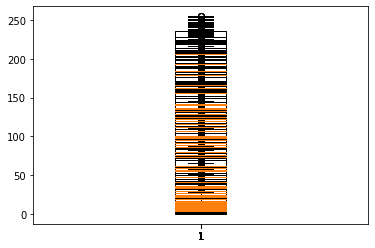

[0.72333333 0.76666667 0.74166667 0.735      0.75166667]
Accuracy: 0.74 (+/- 0.03)
0.7436666666666667 0.014734690736866903


[0.78666667 0.75666667 0.75166667 0.755      0.75833333]
Accuracy: 0.76 (+/- 0.03)
0.7616666666666666 0.012692955176439823


[0.64333333 0.66833333 0.65666667 0.67166667 0.665     ]
Accuracy: 0.66 (+/- 0.02)
0.6609999999999999 0.010143416036468634


[0.77833333 0.75333333 0.74       0.75833333 0.74      ]
Accuracy: 0.75 (+/- 0.03)
0.7539999999999999 0.01416568624058385


In [92]:
print(normalized_scores)

[0.78333333 0.77166667 0.75       0.75333333 0.725     ]


In [27]:
# creating odd list of K for KNN
neighbors = list(range(1, 50, 2))

# empty list that will hold cv scores
cv_scores = []
cv_std = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, Xscale, Ytrain, cv=skf, scoring='accuracy')
    cv_scores.append((k,scores.mean()))
    cv_std.append((k,scores.std()))

0.7555583031988586 0.01183023574271111
0.7555583031988586 0.01183023574271111
0.7555583031988586 0.01183023574271111
0.7555583031988586 0.01183023574271111
0.7555583031988586 0.01183023574271111
0.7555583031988586 0.01183023574271111
0.7555583031988586 0.01183023574271111
0.7555583031988586 0.01183023574271111
0.7555583031988586 0.01183023574271111
0.7555583031988586 0.01183023574271111


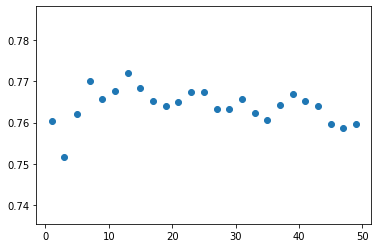

In [96]:
zip(*cv_scores)
plt.scatter(*zip(*cv_scores))
plt.show()

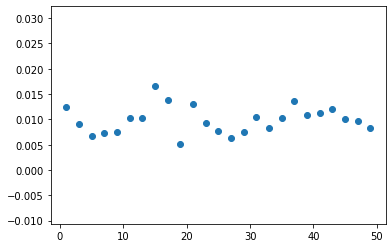

In [97]:
zip(*cv_std)
plt.scatter(*zip(*cv_std))
plt.show()

In [98]:
# creating odd list of K for KNN
neighbors = list(range(50, 100, 2))

# empty list that will hold cv scores
cv_scores_next = []
cv_std_next = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, Xscale, Ytrain, cv=skf, scoring='accuracy')
    cv_scores_next.append((k,scores.mean()))
    cv_std_next.append((k,scores.std()))

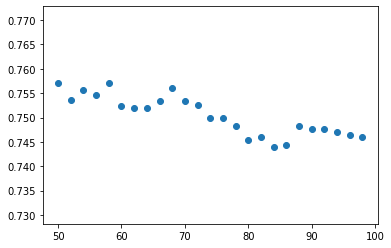

In [99]:
zip(*cv_scores_next)
plt.scatter(*zip(*cv_scores_next))
plt.show()

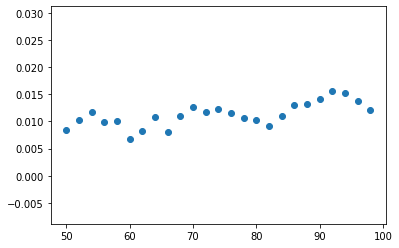

In [100]:
zip(*cv_std_next)
plt.scatter(*zip(*cv_std_next))
plt.show()

In [106]:
print(cv_scores)

[(1, 0.7603333333333333), (3, 0.7516666666666667), (5, 0.7619999999999999), (7, 0.7699999999999999), (9, 0.7656666666666666), (11, 0.7676666666666667), (13, 0.772), (15, 0.7683333333333333), (17, 0.7653333333333332), (19, 0.764), (21, 0.765), (23, 0.7673333333333334), (25, 0.7673333333333334), (27, 0.7633333333333334), (29, 0.7633333333333333), (31, 0.7656666666666666), (33, 0.7623333333333333), (35, 0.7606666666666666), (37, 0.7643333333333333), (39, 0.767), (41, 0.7653333333333333), (43, 0.764), (45, 0.7596666666666666), (47, 0.7586666666666666), (49, 0.7596666666666667)]


Test 12 and 14 now. k=3 seems to be the best

In [107]:
# creating odd list of K for KNN
neighbors = list(range(12, 15, 1))

# empty list that will hold cv scores
cv_scores_mid = []
cv_std_mid = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, Xtrain, Ytrain, cv=skf, scoring='accuracy')
    cv_scores_mid.append((k,scores.mean()))
    cv_std_mid.append((k,scores.std()))

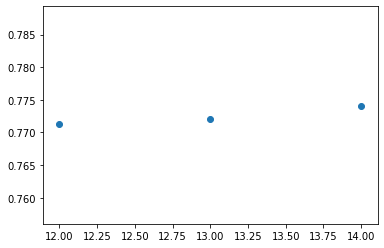

[(12, 0.7713333333333333), (13, 0.772), (14, 0.774)]


In [109]:
zip(*cv_scores_mid)
plt.scatter(*zip(*cv_scores_mid))
plt.show()
print(cv_scores_mid)

so choose k=14

In [13]:
# creating odd list of K for KNN
neighbors = list(range(1, 50, 2))

# empty list that will hold cv scores
cv_scores_def = []
cv_std_def = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, Xtrain, Ytrain, cv=skf, scoring='accuracy')
    cv_scores_def.append((k,scores.mean()))
    cv_std_def.append((k,scores.std()))

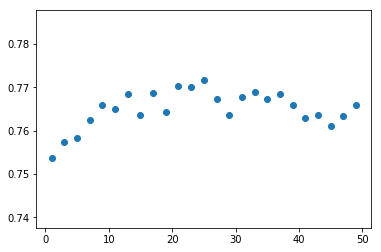

[(1, 0.7536536194082021), (3, 0.7573208314467539), (5, 0.7583297314714763), (7, 0.7623291823958771), (9, 0.7659947435039172), (11, 0.7649952907276595), (13, 0.7683319666628704), (15, 0.7636652944406327), (17, 0.7686630833233796), (19, 0.7643314175872711), (21, 0.7703303064730735), (23, 0.7699941981320318), (25, 0.7716569749730786), (27, 0.767329193507019), (29, 0.7636664074066872), (31, 0.767663630547122), (33, 0.7689964092492849), (35, 0.7673330777770679), (37, 0.7683314064761292), (39, 0.7659969620285982), (41, 0.762996401841857), (43, 0.7636641759190071), (45, 0.760996398138143), (47, 0.7633319574035854), (49, 0.7660008500023612)]


In [14]:
zip(*cv_scores_def)
plt.scatter(*zip(*cv_scores_def))
plt.show()
print(cv_scores_def)

In [15]:
# creating odd list of K for KNN
neighbors = list(range(19, 28, 1))

# empty list that will hold cv scores
cv_scores_zoom = []
cv_std_zoom = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, Xscale, Ytrain, cv=skf, scoring='accuracy')
    cv_scores_zoom.append((k,scores.mean()))
    cv_std_zoom.append((k,scores.std()))

In [ ]:
zip(*cv_scores_zoom)
plt.scatter(*zip(*cv_scores_zoom))
plt.show()
print(cv_scores_zoom)
# still does not match scaled k=14 performance. But close

In [20]:
# Perceptron

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Perceptron

perceptron = Perceptron(random_state = 0)

# IF y if binary or multiclass, Statified is used once cv=n is specified
perceptron_scores = cross_val_score(perceptron, Xscale, Ytrain, cv=5)
print(perceptron_scores.mean(), perceptron_scores.std())

0.6346668601857226 0.03916055404005618


/local/java/python-pip-packages.cs909/lib64/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/local/java/python-pip-packages.cs909/lib64/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/local/java/python-pip-packages.cs909/lib64/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Per

In [21]:
print(perceptron_scores)

[0.67387687 0.605      0.575      0.645      0.67445743]


In [4]:
from sklearn.svm import SVC

LSVM = SVC(C = 1.0, class_weight = 'balanced', kernel = 'linear')

#scores = cross_val_score(LSVM, Xtrain, Ytrain, cv=5)
#print(scores)

#Zp = LSVM.decision_function(Xtrain)


NameError: name 'Ypredict' is not defined

In [35]:
LSVM.fit(Xscale,Ytrain)
Ypredict = LSVM.predict(Xscale)

print( "Train Accuracy", np.mean(Ypredict==Ytrain))

Train Accuracy 0.8663333333333333


In [36]:
LSVMscore = cross_val_score(LSVM, Xscale, Ytrain, cv=5)
print(LSVMscore)

[0.65723794 0.66333333 0.64166667 0.67       0.71452421]


In [ ]:
polySVM = SVC(C = 1, kernel = 'poly', degree = 2,  class_weight = 'balanced', coef0 = 1.0)

polySVM_score = cross_val_score(polySVM, Xscale, Ytrain, cv = 5)

In [13]:
print(polySVM_score)
polySVM_score.mean()

[0.78369384 0.77833333 0.79       0.77166667 0.78964942]


0.7826686518573662

In [14]:
polySVM4 = SVC(C = 1, kernel = 'poly', degree = 4,  class_weight = 'balanced', coef0 = 1.0)

polySVM4_score = cross_val_score(polySVM4, Xscale, Ytrain, cv = 5)

/local/java/python-pip-packages.cs909/lib64/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/local/java/python-pip-packages.cs909/lib64/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/local/java/python-pip-packages.cs909/lib64/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/loc

In [15]:
print(polySVM4_score)
polySVM4_score.mean()

[0.77204659 0.77333333 0.77833333 0.77833333 0.78964942]


0.7783392009422248